# Gather
******************

In [88]:
# Importing the required libraries that we are going to use
import pandas as pd
import numpy as np
import requests
import re
import os
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Gather Twitter archive
**********

In [89]:
# Importing the twitter-archive-enhanced.csv file into a DataFrame
twitter_archive = pd.read_csv("twitter-archive-enhanced.csv", sep="," )

### Gather Image predictions
*********

In [90]:
# Downloading and saveing the image predictions data using requests 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [91]:
file_name = url.split('/')[-1]
file_name

'image-predictions.tsv'

In [92]:
if not os.path.isfile(file_name):
    with open(file_name, 'wb') as f:
        f.write(r.content)

### Gather Tweet json
****************

In [93]:
# Importing the tweet-json.txt file into a DataFrame
json_file = open('tweet-json.txt', encoding='utf-8')
tweet_json = pd.read_json(json_file, lines=True)

json_file.close()

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

In [ ]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [ ]:
# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_1.tweet_id.values
len(tweet_ids)

In [ ]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()

In [ ]:
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

# Assess
***************************

### Twitter archive
****************************

In [94]:
# Display twitter archive 
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [95]:
# We use the info method to assess the DataFrame programmatically
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [96]:
# Find duplicates
sum(twitter_archive['tweet_id'].duplicated())

0

In [97]:
twitter_archive[twitter_archive['expanded_urls'].isnull()].loc[:,['expanded_urls', 
                                                                  'in_reply_to_status_id', 
                                                                  'in_reply_to_user_id',
                                                                 'retweeted_status_id']]

,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id
30,NaN,8.862664e+17,2.281182e+09,NaN
55,NaN,8.816070e+17,4.738443e+07,NaN
64,NaN,8.795538e+17,3.105441e+09,NaN
113,NaN,8.707262e+17,1.648776e+07,NaN
148,NaN,8.634256e+17,7.759620e+07,NaN
179,NaN,8.571567e+17,1.806710e+08,NaN
185,NaN,NaN,NaN,8.563302e+17
186,NaN,8.562860e+17,2.792810e+08,NaN
188,NaN,8.558616e+17,1.943518e+08,NaN
189,NaN,8.558585e+17,1.361572e+07,NaN


In [98]:
# Only four of non-url tweets are not replies. 
my_non_url_non_replies_ids = twitter_archive.iloc[[185, 375, 707, 1445],:].tweet_id
twitter_archive.iloc[[185, 375, 707, 1445],:]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


In [99]:
# Using the describe method:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [100]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [101]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

### Image predictions
*******************

In [102]:
# Display image predictions
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t' )
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [103]:
# We use the info method to assess the DataFrame programmatically
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [104]:
# Find duplicates
sum(image_predictions['tweet_id'].duplicated())


0

In [105]:
sum(image_predictions['jpg_url'].duplicated())

66

In [106]:
# Using the describe method:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


### Tweet json
*********************

In [107]:
# Display tweet json 
tweet_json.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",39467,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,0.0,NaN,NaN,NaN,8853,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",33819,False,This is Tilly. She's just checking pup on you....,NaN,...,0.0,NaN,NaN,NaN,6514,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,NaN,NaN,2017-07-31 00:18:03,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...",25461,False,This is Archie. He is a rare Norwegian Pouncin...,NaN,...,0.0,NaN,NaN,NaN,4328,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,NaN,NaN,2017-07-30 15:58:51,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...",42908,False,This is Darla. She commenced a snooze mid meal...,NaN,...,0.0,NaN,NaN,NaN,8964,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,NaN,NaN,2017-07-29 16:00:24,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...",41048,False,This is Franklin. He would like you to stop ca...,NaN,...,0.0,NaN,NaN,NaN,9774,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [108]:
# We use the info method to assess the DataFrame programmatically
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [109]:
# Using descibe method:
tweet_json.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2354.000000,0.0,2.354000e+03,2.354000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,2211.0,2211.0,2.900000e+01,2.900000e+01,2354.000000
mean,NaN,NaN,8080.968564,NaN,7.426978e+17,7.426978e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,0.0,0.0,8.162686e+17,8.162686e+17,3164.797366
std,NaN,NaN,11814.771334,NaN,6.852812e+16,6.852812e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,0.0,0.0,6.164161e+16,6.164161e+16,5284.770364
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,0.000000
25%,NaN,NaN,1415.000000,NaN,6.783975e+17,6.783975e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,0.0,0.0,7.888183e+17,7.888183e+17,624.500000
50%,NaN,NaN,3603.500000,NaN,7.194596e+17,7.194596e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.340867e+17,8.340867e+17,1473.500000
75%,NaN,NaN,10122.250000,NaN,7.993058e+17,7.993058e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.664587e+17,8.664587e+17,3652.000000
max,NaN,NaN,132810.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,79515.000000


In [110]:
# Find duplicates
sum(tweet_json['id'].duplicated())

0


### Quality:
   
##### * Twitter_archive:

1. Many rows in the twitter enhanced dataset did not mention the stage of dog that is all the four stages in many rows are None.
3. Erroneous dataType of columns in the twitter enhanced dataset such as 'timestamp','retweeted_status_timestamp'.
4. There are missing expanded urls in the twitter enhanced dataset.
5. We do not need retweets and replies in out dataset for analysis so we need to remove retweet_user_id and other columns related to retweets and replies.
6. Some of the names are 'a', 'an', 'actually', 'all', 'by', 'his', 'incredibly', 'just',' life', 'light', etc... which are not invalid.
7. Erroneous some names as 'FrÃ¶nq', 'GÃ²rdÃ³n'.
7. Source names need to be redefined without tags.
8. Erroneous rating_nominator and rating_denominator values 
9. Clean the url from the tweet text.

##### * Image_predictions:

1. Non-descriptive columns' names.
1. Erroneous dataType of Tweet_id columns.
3. Inconsistent capitalization for the predicted breeds(p1, p2, p3).
2. Some predictions of dog breed are false, which means, some images are not dogs.
3. Some of the names of dog breed are not defined, like 'bookshop','bakery','book_jacket', 'orange'.
4. The Image Urls are same for some images 'remove duplicates'.
5. The names of dog in Image prediction Dataset are separated by underscore instead of space.
6. Total number is 2075 insteade of 2356 which means there are some tweets without images and we have to exclude them.

##### * tweet_json:

1. We do not need retweets and replies in out dataset for analysis so we need to remove retweet_user_id and other columns related to retweets and replies.


### Tidiness:

1. Four variables (doggo, floofer, pupper, puppo) should be merged in one column.
4. Values are column names (p1, p2, p3) which are all breed predictions.
4. Timestamp should be split into date and time.
5. We only need one master dataset for our analysis and visualizations, so we will merge all the three datasets collected from different sources.

# Clean
***************************************************

In [111]:
# Copying all datasets
archive_clean = twitter_archive.copy()
image_clean = image_predictions.copy()
tweet_clean = tweet_json.copy()

### Define

There are some mind twist between those two dataframes when dealing with retweets, and tweets without images

#### Code

1. Use the image_prediction table to guide the selection and removal of tweets without photos in the archive table

In [112]:
# creating a list of tweet_ids with images "tweets_with_image" and confirming its length
tweets_with_image = list(image_clean.tweet_id.unique())

# confirming that all the tweets with images exist in the archive dataset
len(tweets_with_image) == archive_clean.tweet_id.isin(tweets_with_image).sum()

# Cleaning in action 
archive_clean = archive_clean[archive_clean.tweet_id.isin(tweets_with_image)]

2. In the follwing part, the following redundant columns (in_reply_to_status_id, in_reply_to_user_id, 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp') will be utilized to shed the retweet and replies from our datasets and then will be dropped.

In [113]:
# Throwback to the archive dataset to extract the tweets that include data in the retweet_status_id.
retweet_entries = archive_clean.retweeted_status_id.notnull()
archive_clean[retweet_entries].shape[0]

# Dropping the retweets from the archive data set
archive_clean = archive_clean[~retweet_entries]

# Extracting replies entries with the same method as the retweets
# Follow the same logic as above but with the column in_reply_to_status_id

# Now we check the image_prediction table for extra tweet ids not in the archive table
np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id)))

# Dropping the retweets and replies ids from the image prediction dataframe
image_clean[~np.logical_not(image_clean.tweet_id.isin(list(archive_clean.tweet_id)))]


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


#### Test

In [114]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      1994 non-null int64
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     1994 non-null object
source                        1994 non-null object
text                          1994 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 1994 non-null object
rating_numerator              1994 non-null int64
rating_denominator            1994 non-null int64
name                          1994 non-null object
doggo                         1994 non-null object
floofer                       1994 non-null object
pupper                        1994 non-null object
puppo                         1994 non-null object
dtypes: float64(4), int64(3), object(1

### Define

Select the columns related to retweets and drop them as it is of no use further.

#### Code

In [115]:
archive_clean.drop(["retweeted_status_id","retweeted_status_user_id","retweeted_status_timestamp","in_reply_to_status_id","in_reply_to_user_id"], axis=1, inplace=True)

#### Test

In [116]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
doggo                 1994 non-null object
floofer               1994 non-null object
pupper                1994 non-null object
puppo                 1994 non-null object
dtypes: int64(3), object(9)
memory usage: 202.5+ KB


### Define


 * Select the four columns of stages and make a new dataframe.
 * Add a new column 'Stage' to the new dataframe.
 * Append the non-null values to column Stage.
 * Add the new column 'Stage' to our original dataset.
 * Drop the four columns 'Doggo', 'Floofer', 'Pupper', 'Puppo' from original dataset.


#### Code

In [117]:
df = pd.DataFrame(archive_clean, columns = ['doggo', 'floofer', 'pupper', 'puppo'])
df.sample(5)

,doggo,floofer,pupper,puppo
678,None,None,None,None
1631,None,None,None,None
1533,None,None,None,None
369,None,None,None,None
2347,None,None,None,None


In [118]:
df['floofer'].replace('None', np.nan, inplace=True)
df['doggo'].replace('None', np.nan, inplace=True)
df['pupper'].replace('None', np.nan, inplace=True)
df['puppo'].replace('None', np.nan, inplace=True)

In [119]:
df.sample(5)

,doggo,floofer,pupper,puppo
2076,NaN,NaN,NaN,NaN
2165,NaN,NaN,NaN,NaN
1403,NaN,NaN,NaN,NaN
1765,NaN,NaN,NaN,NaN
892,NaN,NaN,NaN,NaN


In [120]:
df['Stage']=None

In [121]:
df.sample(5)

,doggo,floofer,pupper,puppo,Stage
1701,NaN,NaN,NaN,NaN,None
1496,NaN,NaN,NaN,NaN,None
1572,NaN,NaN,NaN,NaN,None
1897,NaN,NaN,pupper,NaN,None
143,NaN,NaN,NaN,NaN,None


In [122]:
df['Stage'] = df.apply(lambda row: ','.join(row.dropna()
          .astype(str).astype(str)), axis=1)
df.replace(r'^\s*$', np.nan, regex=True,inplace=True)

In [123]:
df.sample(5)

,doggo,floofer,pupper,puppo,Stage
718,NaN,NaN,NaN,NaN,NaN
2080,NaN,NaN,NaN,NaN,NaN
2013,NaN,NaN,NaN,NaN,NaN
795,NaN,NaN,NaN,NaN,NaN
771,NaN,NaN,NaN,NaN,NaN


In [124]:
df['Stage'].value_counts()

pupper           203
doggo             63
puppo             22
doggo,pupper       9
floofer            7
doggo,floofer      1
doggo,puppo        1
Name: Stage, dtype: int64

In [125]:
archive_clean.drop(["doggo","floofer","pupper","puppo"],axis=1, inplace=True)

In [126]:
archive_clean['Stage']=df['Stage']

#### Test

In [127]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Stage
1722,680115823365742593,2015-12-24 20:00:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ozzy. He woke up 2 minutes before he h...,https://twitter.com/dog_rates/status/680115823...,9,10,Ozzy,NaN
2173,669324657376567296,2015-11-25 01:20:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Ralf. He's a miniature Buick DiCaprio. Ca...,https://twitter.com/dog_rates/status/669324657...,11,10,Ralf,NaN
1111,733482008106668032,2016-05-20 02:18:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""Ello this is dog how may I assist"" ...10/10 h...",https://twitter.com/dog_rates/status/733482008...,10,10,None,NaN
910,757611664640446465,2016-07-25 16:21:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cooper. He tries to come across as fei...,https://twitter.com/dog_rates/status/757611664...,12,10,Cooper,NaN
2286,667182792070062081,2015-11-19 03:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Timison. He just told an awful joke bu...,https://twitter.com/dog_rates/status/667182792...,10,10,Timison,NaN


In [128]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null object
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
Stage                 306 non-null object
dtypes: int64(3), object(6)
memory usage: 155.8+ KB


### Define

Select the column 'timestamp' and change the DataType of timestamp from string to datetime.

#### Code

In [129]:
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'])

#### Test

In [130]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
Stage                 306 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 155.8+ KB


### Define

Select rows with missing values of expand urls and remove them.

#### Code

In [131]:
archive_clean.dropna(subset=['expanded_urls'],inplace=True)

#### Test

In [132]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Stage
279,839990271299457024,2017-03-10 00:04:21,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sojourner. His nose is a Fibonacci Spiral...,https://twitter.com/dog_rates/status/839990271...,13,10,Sojourner,NaN
480,815736392542261248,2017-01-02 01:48:06,"<a href=""http://twitter.com/download/iphone"" r...",This is Akumi. It's his birthday. He received ...,https://twitter.com/dog_rates/status/815736392...,11,10,Akumi,NaN
1736,679722016581222400,2015-12-23 17:55:32,"<a href=""http://twitter.com/download/iphone"" r...",This is Mike. He is a Jordanian Frito Pilates....,https://twitter.com/dog_rates/status/679722016...,8,10,Mike,NaN
514,811627233043480576,2016-12-21 17:39:46,"<a href=""http://twitter.com/download/iphone"" r...",This is Augie. He's a savage. Doesn't give a h...,https://twitter.com/dog_rates/status/811627233...,10,10,Augie,NaN
1580,687127927494963200,2016-01-13 04:23:58,"<a href=""http://twitter.com/download/iphone"" r...",Meet Gordon. He's an asshole. 9/10 would still...,https://twitter.com/dog_rates/status/687127927...,9,10,Gordon,NaN


In [133]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              1994 non-null int64
timestamp             1994 non-null datetime64[ns]
source                1994 non-null object
text                  1994 non-null object
expanded_urls         1994 non-null object
rating_numerator      1994 non-null int64
rating_denominator    1994 non-null int64
name                  1994 non-null object
Stage                 306 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 155.8+ KB


### Define

Select invalid Names, which most probably starts with lower case letter and set those cells to None.

#### Code

In [134]:
archive_clean.loc[archive_clean['name'] == archive_clean['name'].str.lower(), 'name'] = None

#### Test

In [135]:
archive_clean['name'].value_counts()

None        546
Charlie      11
Oliver       10
Lucy         10
Cooper       10
Penny         9
Tucker        9
Winston       8
Sadie         8
Toby          7
Lola          7
Daisy         7
Jax           6
Bella         6
Bo            6
Stanley       6
Koda          6
Oscar         5
Buddy         5
Bailey        5
Milo          5
Rusty         5
Leo           5
Dave          5
Chester       5
Louis         5
Scout         5
Winnie        4
Oakley        4
Finn          4
           ... 
Hero          1
Kirk          1
Carper        1
Ralphie       1
Mo            1
Anthony       1
Mutt          1
Smiley        1
Flash         1
Nico          1
Jockson       1
General       1
Swagger       1
Jaspers       1
Mason         1
Ginger        1
Sephie        1
Milky         1
Amélie        1
Fred          1
Mauve         1
Jarvis        1
Beya          1
Sprout        1
Grizzie       1
Howie         1
Napolean      1
Harry         1
Geno          1
Timber        1
Name: name, Length: 914,

### Define

Select the source column and extract the text.

#### Code

In [136]:
archive_clean['source'] = archive_clean['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0])

#### Test

In [137]:
archive_clean['source'].value_counts()

Twitter for iPhone    1955
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

In [138]:
archive_clean.sample(5)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,Stage
1945,673707060090052608,2015-12-07 03:34:14,Twitter for iPhone,This is Raymond. He's absolutely terrified of ...,https://twitter.com/dog_rates/status/673707060...,10,10,Raymond,pupper
1614,685307451701334016,2016-01-08 03:50:03,Twitter for iPhone,Say hello to Petrick. He's an Altostratus Floo...,https://twitter.com/dog_rates/status/685307451...,11,10,Petrick,floofer
1829,676237365392908289,2015-12-14 03:08:46,Twitter for iPhone,Say hello to Winston. He has no respect for th...,https://twitter.com/dog_rates/status/676237365...,8,10,Winston,NaN
1455,695409464418041856,2016-02-05 00:51:51,Twitter for iPhone,This is Bob. He just got back from his job int...,https://twitter.com/dog_rates/status/695409464...,10,10,Bob,NaN
1339,704871453724954624,2016-03-02 03:30:25,Twitter for iPhone,I found a forest Pipsy. 12/10 https://t.co/mIQ...,https://twitter.com/dog_rates/status/704871453...,12,10,None,NaN


********************************************

### Define

Select the columns for which dog breed classifier is true and remove the images which are not dogs.

#### Code

In [139]:
image_clean = image_clean.query('p1_dog==True and p2_dog==True and p3_dog==True')

#### Test

In [140]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
44,666781792255496192,https://pbs.twimg.com/media/CUDigRXXIAATI_H.jpg,1,Italian_greyhound,0.618316,True,Weimaraner,0.151363,True,vizsla,0.085989,True
1938,860524505164394496,https://pbs.twimg.com/media/C_EyeKuXkAAdxY-.jpg,1,Bedlington_terrier,0.286558,True,toy_poodle,0.235193,True,Lakeland_terrier,0.087951,True
1323,756651752796094464,https://pbs.twimg.com/media/CoAqwPTW8AAiJlz.jpg,1,Pembroke,0.294808,True,kelpie,0.282301,True,Cardigan,0.112601,True
1968,868552278524837888,https://pbs.twimg.com/media/DA23sCeVoAE3uF0.jpg,1,whippet,0.378151,True,Italian_greyhound,0.275935,True,American_Staffordshire_terrier,0.094991,True
1383,765669560888528897,https://pbs.twimg.com/media/CqA0XcYWAAAzltT.jpg,1,beagle,0.993333,True,Walker_hound,0.002902,True,basset,0.002415,True


In [141]:
image_clean.query('p1_dog==False and p2_dog==False and p3_dog==False').shape[0]

0

### Define

Select the dog breed prediction columns then replace underscore in dog breed's name with space.

#### Code

In [142]:
image_clean['p1'] = image_clean['p1'].replace('_', ' ', regex=True)
image_clean['p2'] = image_clean['p2'].replace('_', ' ', regex=True)
image_clean['p3'] = image_clean['p3'].replace('_', ' ', regex=True)

#### Test

In [143]:
image_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2064,890006608113172480,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
1213,743222593470234624,https://pbs.twimg.com/media/ClB09z0WYAAA1jz.jpg,1,kuvasz,0.350629,True,soft-coated wheaten terrier,0.182782,True,golden retriever,0.087662,True
1472,779834332596887552,https://pbs.twimg.com/media/CtKHLuCWYAA2TTs.jpg,1,golden retriever,0.993830,True,cocker spaniel,0.003143,True,Great Pyrenees,0.000917,True
648,681694085539872773,https://pbs.twimg.com/media/CXXdJ7CVAAALu23.jpg,1,toy poodle,0.920992,True,miniature poodle,0.060857,True,Maltese dog,0.006064,True
994,708130923141795840,https://pbs.twimg.com/media/CdPJUWIWIAAIchl.jpg,1,French bulldog,0.710354,True,Chihuahua,0.262302,True,Cardigan,0.006904,True


### Define

Change the title of non-descriptive columns to more appropriate ones.

#### Code

In [144]:
image_clean = image_clean.rename(columns={'jpg_url': 'image_url',
                                                                  'img_num': 'image_number',
                                                                  'p1': 'top_prediction',
                                                                  'p1_conf': 'top_pred_conf',
                                                                  'p2': 'second_prediction',
                                                                  'p2_conf': 'second_pred_conf',
                                                                  'p3': 'third_prediction',
                                                                  'p3_conf': 'third_pred_conf',
                                                                  'p1_dog': 'is_dog_top_pred',
                                                                  'p2_dog': 'is_dog_sec_pred',
                                                                  'p3_dog': 'is_dog_third_pred',
                                                                 })

#### Test

In [145]:
image_clean.sample(5)

,tweet_id,image_url,image_number,top_prediction,top_pred_conf,is_dog_top_pred,second_prediction,second_pred_conf,is_dog_sec_pred,third_prediction,third_pred_conf,is_dog_third_pred
1358,760656994973933572,https://pbs.twimg.com/media/Co5lf-KW8AAIwJw.jpg,1,golden retriever,0.760546,True,Labrador retriever,0.232079,True,redbone,0.002874,True
71,667200525029539841,https://pbs.twimg.com/media/CUJfVMPXIAAgbue.jpg,1,Siberian husky,0.694904,True,malamute,0.232006,True,Eskimo dog,0.050635,True
501,675853064436391936,https://pbs.twimg.com/media/CWEcxqWVEAAHyGH.jpg,1,Labrador retriever,0.868367,True,golden retriever,0.043305,True,vizsla,0.028207,True
322,671866342182637568,https://pbs.twimg.com/media/CVLy3zFWoAA93qJ.jpg,1,Labrador retriever,0.875614,True,Chihuahua,0.032182,True,golden retriever,0.017232,True
79,667453023279554560,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,1,Labrador retriever,0.825670,True,French bulldog,0.056639,True,Staffordshire bullterrier,0.054018,True


### Define

Merging all the datasets and make tweet_id as main key as it unique for everyone.

#### Code

In [146]:
master =pd.merge(left=archive_clean,right=tweet_clean,left_on='tweet_id',right_on='id',how='inner')
master.drop(['id', 'contributors', 'coordinates', 'geo','source_y','text', 'full_text', 'created_at', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'place', 'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweeted_status'],axis=1,inplace=True)

#### Test

In [147]:
master.head()

,tweet_id,timestamp,source_x,expanded_urls,rating_numerator,rating_denominator,name,Stage,display_text_range,entities,...,favorited,id_str,is_quote_status,lang,possibly_sensitive,possibly_sensitive_appealable,retweet_count,retweeted,truncated,user
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,NaN,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,False,892420643555336192,False,en,0.0,0.0,8853,False,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,False,892177421306343424,False,en,0.0,0.0,6514,False,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,False,891815181378084864,False,en,0.0,0.0,4328,False,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,NaN,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,False,891689557279858688,False,en,0.0,0.0,8964,False,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...",...,False,891327558926688256,False,en,0.0,0.0,9774,False,False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [148]:
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 22 columns):
tweet_id                         1994 non-null int64
timestamp                        1994 non-null datetime64[ns]
source_x                         1994 non-null object
expanded_urls                    1994 non-null object
rating_numerator                 1994 non-null int64
rating_denominator               1994 non-null int64
name                             1896 non-null object
Stage                            306 non-null object
display_text_range               1994 non-null object
entities                         1994 non-null object
extended_entities                1994 non-null object
favorite_count                   1994 non-null int64
favorited                        1994 non-null bool
id_str                           1994 non-null int64
is_quote_status                  1994 non-null bool
lang                             1994 non-null object
possibly_sensitive             

In [149]:
master_final=pd.merge(left = master,right = image_clean, on='tweet_id',how='inner')

###### Test

In [150]:
master_final.sample(5)

,tweet_id,timestamp,source_x,expanded_urls,rating_numerator,rating_denominator,name,Stage,display_text_range,entities,...,image_number,top_prediction,top_pred_conf,is_dog_top_pred,second_prediction,second_pred_conf,is_dog_sec_pred,third_prediction,third_pred_conf,is_dog_third_pred
214,821044531881721856,2017-01-16 17:20:45,Twitter for iPhone,https://twitter.com/dog_rates/status/821044531...,12,10,Flash,NaN,"[0, 125]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Old English sheepdog,0.148020,True,Airedale,0.133534,True,Tibetan mastiff,0.120903,True
869,680913438424612864,2015-12-27 00:49:49,Twitter for iPhone,https://twitter.com/dog_rates/status/680913438...,11,10,Griswold,NaN,"[0, 100]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Pomeranian,0.615678,True,golden retriever,0.126455,True,Chihuahua,0.087184,True
47,877201837425926144,2017-06-20 16:29:50,Twitter for iPhone,https://twitter.com/dog_rates/status/877201837...,12,10,Nelly,NaN,"[0, 128]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Pembroke,0.931120,True,Cardigan,0.068698,True,basenji,0.000082,True
687,702539513671897089,2016-02-24 17:04:07,Twitter for iPhone,https://twitter.com/dog_rates/status/702539513...,12,10,None,NaN,"[0, 136]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,3,Pomeranian,0.714367,True,Shih-Tzu,0.040574,True,silky terrier,0.032511,True
499,747600769478692864,2016-06-28 01:21:27,Twitter for iPhone,https://twitter.com/dog_rates/status/747600769...,10,10,Bookstore,NaN,"[0, 104]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Chesapeake Bay retriever,0.804363,True,Weimaraner,0.054431,True,Labrador retriever,0.043268,True


In [151]:
master_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 0 to 1202
Data columns (total 33 columns):
tweet_id                         1203 non-null int64
timestamp                        1203 non-null datetime64[ns]
source_x                         1203 non-null object
expanded_urls                    1203 non-null object
rating_numerator                 1203 non-null int64
rating_denominator               1203 non-null int64
name                             1148 non-null object
Stage                            190 non-null object
display_text_range               1203 non-null object
entities                         1203 non-null object
extended_entities                1203 non-null object
favorite_count                   1203 non-null int64
favorited                        1203 non-null bool
id_str                           1203 non-null int64
is_quote_status                  1203 non-null bool
lang                             1203 non-null object
possibly_sensitive             

******

## Storing
******

In [152]:
master_final.to_csv('twitter_archive_master.csv',index=False)

dfmaster = pd.read_csv('twitter_archive_master.csv')
dfmaster

,tweet_id,timestamp,source_x,expanded_urls,rating_numerator,rating_denominator,name,Stage,display_text_range,entities,...,image_number,top_prediction,top_pred_conf,is_dog_top_pred,second_prediction,second_pred_conf,is_dog_sec_pred,third_prediction,third_pred_conf,is_dog_third_pred
0,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,NaN,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
1,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,NaN,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,NaN,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...",...,2,basset,0.555712,True,English springer,0.225770,True,German short-haired pointer,0.175219,True
3,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,https://twitter.com/dog_rates/status/890729181...,13,10,None,NaN,"[0, 118]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,2,Pomeranian,0.566142,True,Eskimo dog,0.178406,True,Pembroke,0.076507,True
4,890609185150312448,2017-07-27 16:25:51,Twitter for iPhone,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,NaN,"[0, 122]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...",...,1,Irish terrier,0.487574,True,Irish setter,0.193054,True,Chesapeake Bay retriever,0.118184,True
5,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,"[0, 133]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True
6,890006608113172480,2017-07-26 00:31:25,Twitter for iPhone,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,NaN,"[0, 130]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...",...,1,Samoyed,0.957979,True,Pomeranian,0.013884,True,chow,0.008167,True
7,889665388333682689,2017-07-25 01:55:32,Twitter for iPhone,https://twitter.com/dog_rates/status/889665388...,13,10,None,puppo,"[0, 106]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,Pembroke,0.966327,True,Cardigan,0.027356,True,basenji,0.004633,True
8,889638837579907072,2017-07-25 00:10:02,Twitter for iPhone,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,NaN,"[0, 91]","{'hashtags': [], 'symbols': [], 'user_mentions...",...,1,French bulldog,0.991650,True,boxer,0.002129,True,Staffordshire bullterrier,0.001498,True
9,889531135344209921,2017-07-24 17:02:04,Twitter for iPhone,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,puppo,"[0, 118]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...",...,1,golden retriever,0.953442,True,Labrador retriever,0.013834,True,redbone,0.007958,True


**************

## Analyze & Visualize

In [153]:
dfmaster.describe()

,tweet_id,rating_numerator,rating_denominator,favorite_count,id_str,possibly_sensitive,possibly_sensitive_appealable,retweet_count,image_number,top_pred_conf,second_pred_conf,third_pred_conf
count,1.203000e+03,1203.000000,1203.000000,1203.000000,1.203000e+03,1203.0,1203.0,1203.000000,1203.000000,1203.000000,1203.000000,1203.000000
mean,7.418491e+17,11.587697,10.573566,9291.555278,7.418491e+17,0.0,0.0,2752.620948,1.225270,0.627982,0.143012,0.061224
std,6.916229e+16,7.890341,7.022559,12551.733448,6.916229e+16,0.0,0.0,4514.580768,0.582575,0.253728,0.103995,0.052930
min,6.660209e+17,1.000000,2.000000,81.000000,6.660209e+17,0.0,0.0,16.000000,1.000000,0.044333,0.000056,0.000008
25%,6.784173e+17,10.000000,10.000000,2243.500000,6.784173e+17,0.0,0.0,652.500000,1.000000,0.416938,0.055778,0.015070
50%,7.153425e+17,11.000000,10.000000,4537.000000,7.153425e+17,0.0,0.0,1425.000000,1.000000,0.636169,0.129683,0.048550
75%,7.999497e+17,12.000000,10.000000,11697.500000,7.999497e+17,0.0,0.0,3220.000000,1.000000,0.856275,0.207010,0.094808
max,8.921774e+17,165.000000,150.000000,132810.000000,8.921774e+17,0.0,0.0,56625.000000,4.000000,0.999885,0.467678,0.273419




  *  The mean dog rating for the dataset is 1203.
  *  On average 9291 twitter users favorite each WeRateDogs original tweet.
  *  The mean retweet count is substantially lower: 2752.62.
  *  The most liked tweet was liked by 132810 users.
  *  The most retweeted tweet was retweeted 56625 times.



##### * What is the most common dog stage?

In [154]:
dfmaster['Stage'].value_counts()

pupper           119
doggo             39
puppo             18
doggo,pupper       6
floofer            6
doggo,floofer      1
doggo,puppo        1
Name: Stage, dtype: int64

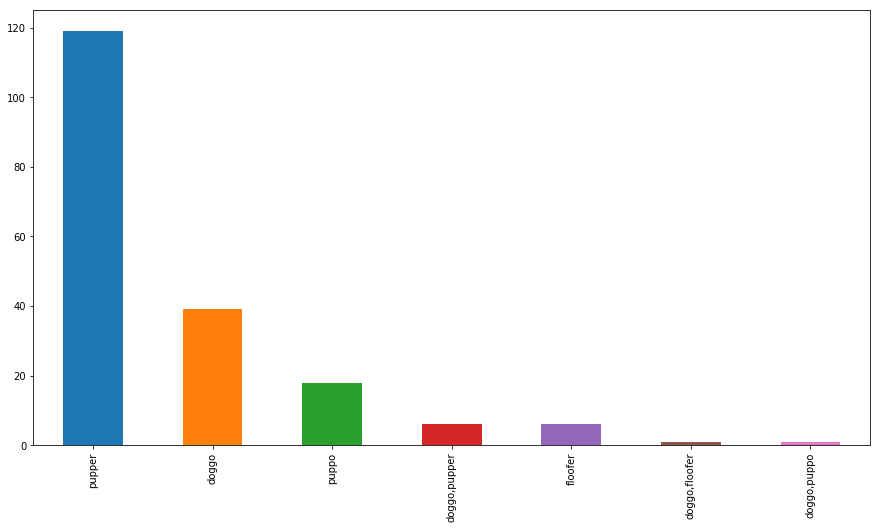

In [155]:
dfmaster[dfmaster['Stage']!='None']['Stage'].value_counts().plot(kind = 'bar', figsize=(15, 8));

we see that pupper is the most type/stage of dogs

##### * Is retweet_count related to favorite_count ?

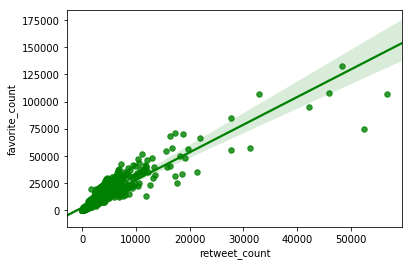

In [156]:
sns.regplot(data=dfmaster,x='retweet_count',y='favorite_count', marker='o', color='green', scatter_kws={'s':30});

we see that retweet count and favorite count are strongly related to each other with a positive correlation

##### * What is the most source to post tweets by WeRateDogs?

In [157]:
dfmaster['source_x'].value_counts()

Twitter for iPhone    1184
Twitter Web Client      14
TweetDeck                5
Name: source_x, dtype: int64

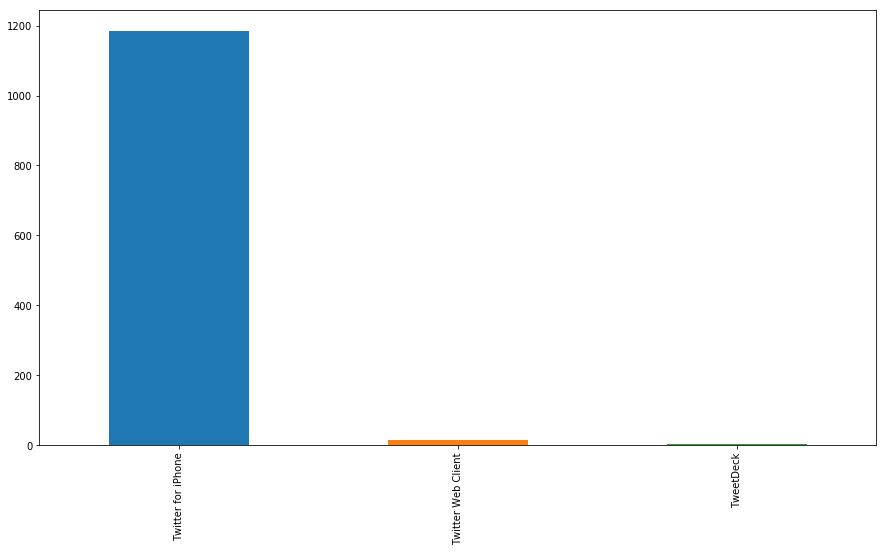

In [158]:
dfmaster['source_x'].value_counts().plot(kind = 'bar', figsize = (15, 8));

we see that Twitter for iPhone is the most used source to post tweets and the least is TweetDeck

##### * What is the most 5 predictions in top_prediction ?

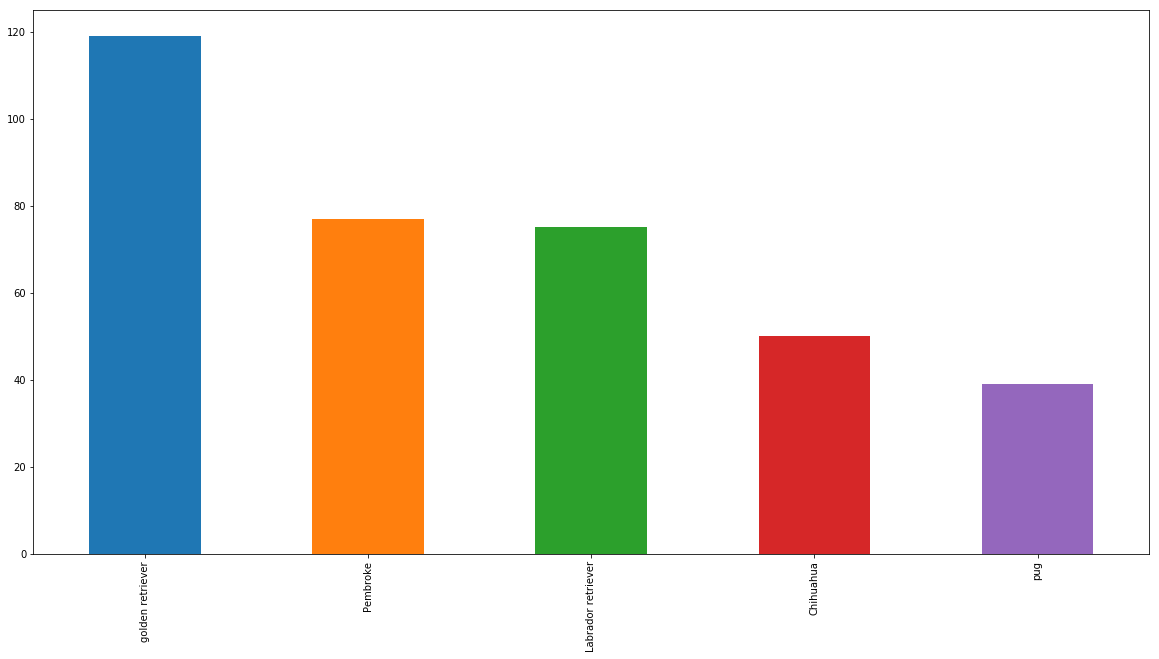

In [159]:
dfmaster['top_prediction'].value_counts().head().plot(kind = 'bar', figsize = (20, 10));

##### * What is the most 5 predictions in second_prediction ?

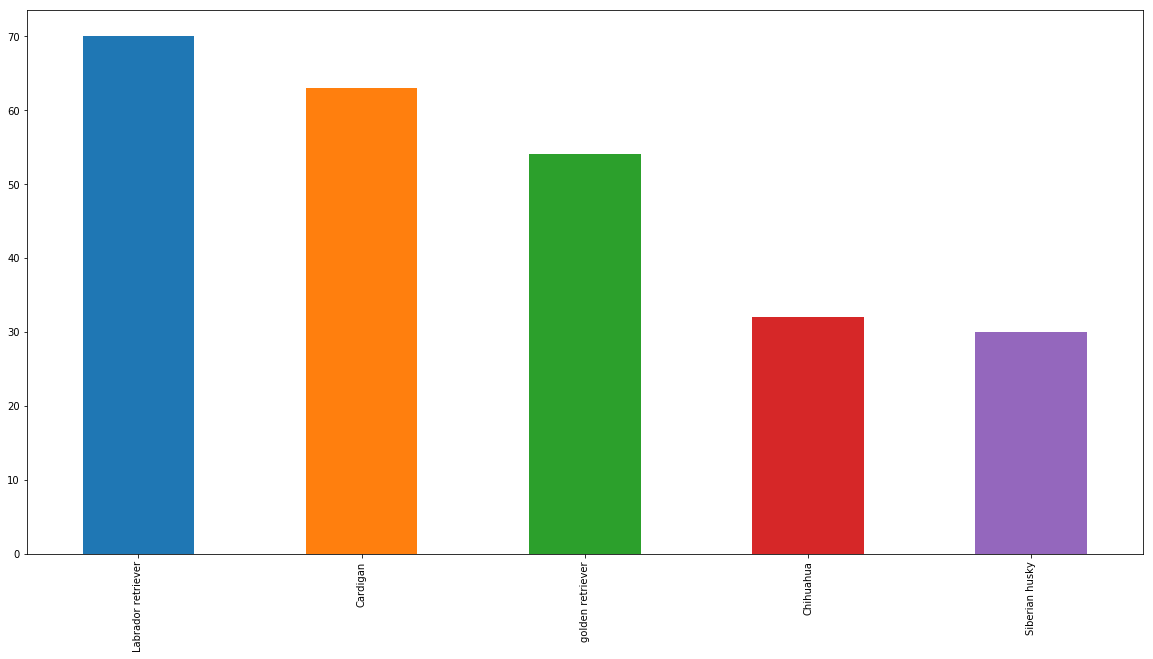

In [160]:
dfmaster['second_prediction'].value_counts().head().plot(kind = 'bar', figsize = (20,10));

##### * What is the most 5 predictions in third_prediction ?

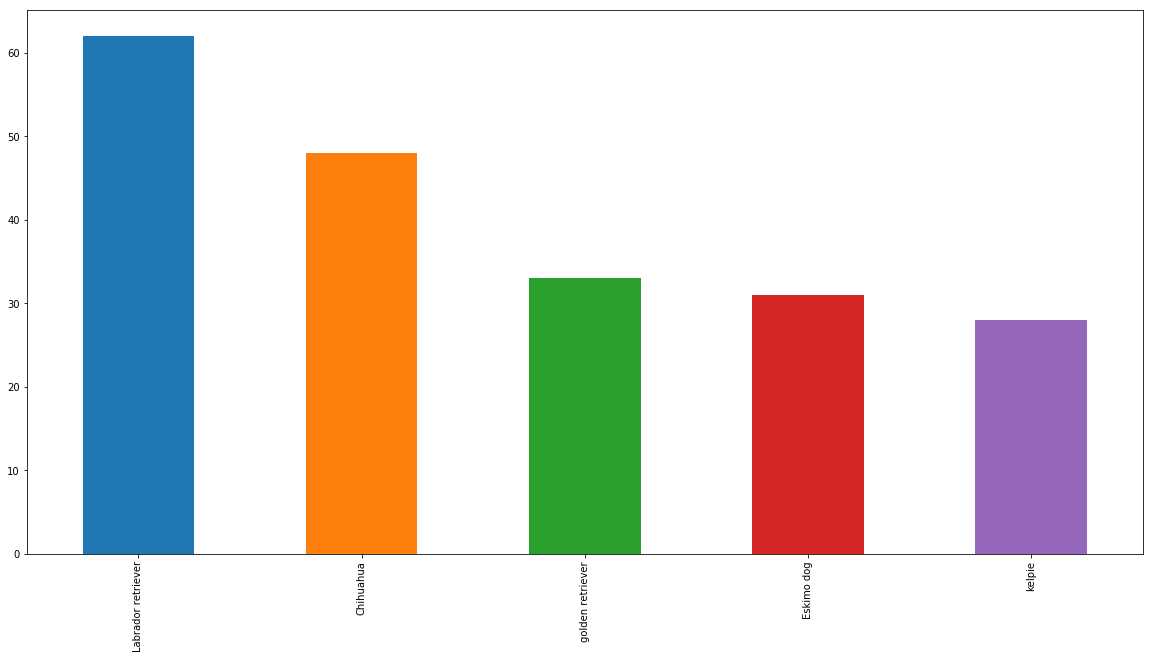

In [161]:
dfmaster['third_prediction'].value_counts().head().plot(kind = 'bar', figsize = (20,10));